In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from time import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer

from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier

from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier


from sklearn.model_selection import cross_validate

# Importamos el dataset limpio y lematizado

In [3]:
df_lem = pd.read_csv('../../cyberbullying/data/lem_all_df.csv')
df_lem.head()

,text,target
0,this one can make an analogy in mathematical t...,0.0
1,clarification for you and zundark s right i sh...,0.0
2,elected or electoral jhk,0.0
3,this is such a fun entry devotchka i once had ...,0.0
4,please relate the ozone hole to increases in c...,0.0


In [4]:
df_lem.shape

(227423, 2)

## Distribución del dataset

In [5]:
def plot_dist(df):
    plt.figure(figsize = (7,7))
    sorted_counts = df['target'].value_counts()
    plt.pie(sorted_counts, labels = ['not bullying', 'bullying'], startangle = 90, counterclock = False,
            wedgeprops = {'width' : 0.6}, autopct='%1.1f%%', pctdistance = 0.7,
            textprops = {'color': 'black', 'fontsize' : 15}, shadow = True,
            colors = sns.color_palette("Paired")[7:])
    plt.text(x = -0.35, y = 0, s = f'Total comments: {df.shape[0]}')
    plt.title('Distribution of Comments in the Dataset', fontsize = 16);

Tomamos una muestra del dataset para investigar

In [6]:
percentage_used = 0.2
df_sample = df_lem.sample(frac=percentage_used, random_state=0)

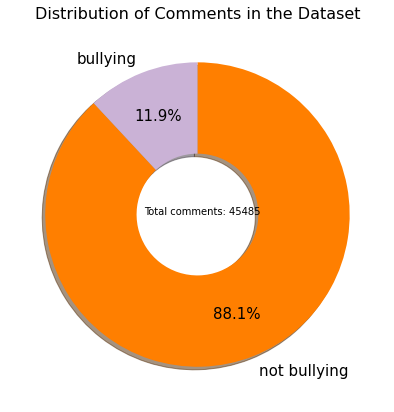

In [7]:
plot_dist(df_sample)

# Holdout

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df_sample['text'], df_sample['target'], test_size=0.3, random_state=0)

In [9]:
X_train = pd.DataFrame(data=X_train, columns=['text'])
X_test = pd.DataFrame(data=X_test, columns=['text'])

## Balanceamos el dataset (paso descartado)

In [10]:
def balance_df(X, y, ratio=0.3):
    df = pd.DataFrame({'text': X, 'target': y})
    df_class_0 = df[df['target'] == 0]
    df_class_1 = df[df['target'] == 1]
    df_class_1_len = df_class_1.shape[0]
    
    df_class_0_new = df_class_0.sample(int(df_class_1_len * (1-ratio)/ratio))
    df_new = pd.concat([df_class_0_new, df_class_1]).sample(frac=1).reset_index(drop=True)
    
    X = df_new['text']
    y = df_new['target']

    return X, y

#X_train, y_train = balance_df(X_train, y_train, ratio=0.1)
# no lo usamos

# Definimos métricas y funciones

In [11]:
scoring = ['accuracy', 'precision', 'recall', 'f1']
scorer = make_scorer(f1_score)

In [12]:
def scores(cv_results):
    score_results = {'accuracy': None, 'precision': None, 'recall': None, 'f1': None, 'time': None}
    for key in score_results.keys():
        if key == 'time':
            score_results[key] = round(cv_results['fit_time'].mean() + cv_results['score_time'].mean(), 1)
        else:
            score_results[key] = round(cv_results[f'test_{key}'].mean(), 4)
    return score_results

In [13]:
def conf_mx_all(y_test, y_pred):
    
    cm = confusion_matrix(y_test, y_pred)
    
    TN = cm[0,0]
    TP = cm[1,1]
    FN = cm[1,0]
    FP = cm[0,1]
    
    recall = np.round_(TP/(TP+FN),3)
    precision = np.round_(TP/(TP+FP),3)
    accuracy = np.round_((TP+TN)/(TP+TN+FP+FN),3)
    F1= np.round((2*precision*recall)/(precision+recall), 3)
    
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")
    print(f"Accuracy: {accuracy}")
    print(f"F1-score: {F1}")
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1])
    disp.plot();
    
    return recall, precision, accuracy, F1

In [14]:
def get_best_model(model, type_):
    name = model[type_]
    params = model[f'{type_} Params']
    return eval(f'{name}(**{params})')

Definimos la pipeline para evaluar los distintos algoritmos

In [15]:
def pipeline(vectorizer_list, learner_list, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    def list_params(new_class):
        name = new_class.__class__.__name__
        default_class = eval(name + '()').get_params()
        new_class = new_class.get_params()

        new_dict = {}

        for key in new_class.keys():
            if new_class[key] != default_class[key]:
                new_dict[key] = new_class[key]
        return new_dict
    
    
    # Get length of Training Data:
    size = len(y_train)
    
    results = {}
    final_results = []
    
    for vectorizer in vectorizer_list:
        
        X_train_vec = vectorizer.fit_transform(X_train['text'])
        X_test_vec = vectorizer.transform(X_test['text'])
        
    
        for learner in learner_list:

            # Store the vectorizer name and params:
            results['Vectorizer'] = vectorizer.__class__.__name__
            results['Vectorizer Params'] = list_params(vectorizer)

            # Store the learner name and params:
            results['Algorithm'] = learner.__class__.__name__
            results['Algorithm Params'] = list_params(learner)

            # Fit the learner:
            start = time() # Get start time
            learner = learner.fit(X_train_vec, y_train)
            end = time() # Get end time

            # Store the training time
            results['Training Time'] = round(end - start, 2)

            start = time() # Get start time
            predictions_test = learner.predict(X_test_vec)
            predictions_train = learner.predict(X_train_vec)
            end = time() # Get end time

            # Store the prediction time
            results['Prediction Time'] = round(end - start, 2)

            # Compute the F1 Score on Test Set
            results['f1'] = round(f1_score(y_test, predictions_test), 4)

            # Compute the Recall on Test Set
            results['recall'] = round(recall_score(y_test, predictions_test), 4)
            
            # Compute the Precision on Test Set
            results['precision'] = round(precision_score(y_test, predictions_test), 4)
            
            # Compute the Accuracy on Test Set
            results['accuracy'] = round(accuracy_score(y_test, predictions_test), 4)

            final_results.append(results.copy())
            
    # Return a dataframe of the results
    return final_results

## Instanciamos los distintos vectorizadores y clasificadores

In [16]:
# make a list of vectorizers
vectorizers = [TfidfVectorizer()]

# make a list of models
models = [MultinomialNB(),
          DecisionTreeClassifier(),
          LinearSVC(),
          AdaBoostClassifier(),
          RandomForestClassifier(),
          BaggingClassifier(),
          LogisticRegression(solver='liblinear'),
          SGDClassifier(),
          KNeighborsClassifier()
]

In [17]:
%%time

re = pipeline(vectorizers, models, X_train, y_train, X_test, y_test)
results = pd.DataFrame(re)

results = results.sort_values(by = 'f1', ascending = False).reset_index(drop = True)

best_model = results

results

CPU times: user 5min 13s, sys: 12.4 s, total: 5min 25s
Wall time: 5min 20s


,Vectorizer,Vectorizer Params,Algorithm,Algorithm Params,Training Time,Prediction Time,f1,recall,precision,accuracy
0,TfidfVectorizer,{},LinearSVC,{},0.14,0.00,0.6054,0.5107,0.7431,0.9182
1,TfidfVectorizer,{},BaggingClassifier,{},173.60,0.40,0.5280,0.4189,0.7141,0.9080
2,TfidfVectorizer,{},LogisticRegression,{'solver': 'liblinear'},0.35,0.01,0.5176,0.3854,0.7878,0.9118
3,TfidfVectorizer,{},KNeighborsClassifier,{},0.00,54.04,0.5176,0.4045,0.7182,0.9074
4,TfidfVectorizer,{},DecisionTreeClassifier,{},24.97,0.06,0.5008,0.4660,0.5412,0.8859
5,TfidfVectorizer,{},AdaBoostClassifier,{},6.59,0.54,0.4984,0.3765,0.7371,0.9069
6,TfidfVectorizer,{},SGDClassifier,{},0.08,0.01,0.4862,0.3407,0.8484,0.9115
7,TfidfVectorizer,{},RandomForestClassifier,{},55.31,2.59,0.3477,0.2208,0.8186,0.8983
8,TfidfVectorizer,{},MultinomialNB,{},0.02,0.01,0.0812,0.0424,0.9861,0.8823


Tomamos el mejor vectorizador y estimador (el primero de la lista)

In [18]:
best_vectorizer = get_best_model(results.iloc[0], 'Vectorizer')
best_model = get_best_model(results.iloc[0], 'Algorithm')

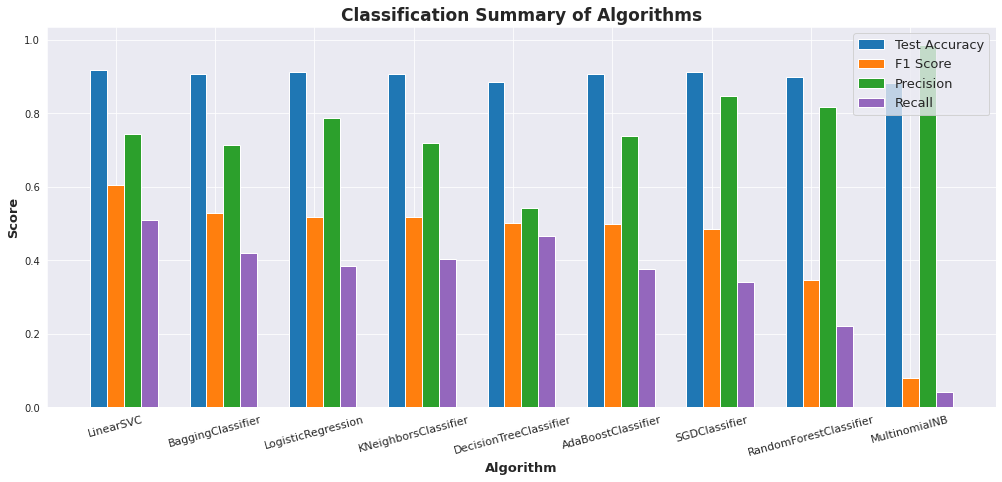

In [20]:
def plot_algorithms(results):
    sns.set_style('darkgrid')
    plt.figure(figsize = (17, 7))

    barWidth = 0.17


    # set height of bar
    bars1 = results['accuracy']
    bars2 = results['f1']
    bars3 = results['precision']
    bars4 = results['recall']


    # Set position of bar on X axis
    r1 = np.arange(len(bars1))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    r4 = [x + barWidth for x in r3]


    # Make the plot
    pal = sns.color_palette()
    plt.bar(r1, bars1, color= pal[0], width=barWidth, edgecolor='white', label='Test Accuracy')
    plt.bar(r2, bars2, color= pal[1], width=barWidth, edgecolor='white', label='F1 Score')
    plt.bar(r3, bars3, color= pal[2], width=barWidth, edgecolor='white', label='Precision')
    plt.bar(r4, bars4, color= pal[4], width=barWidth, edgecolor='white', label='Recall')


    # Add xticks on the middle of the group bars
    plt.xlabel('Algorithm', fontweight='bold', fontsize = 13)
    plt.ylabel('Score', fontweight = 'bold', fontsize = 13)
    plt.xticks([r + barWidth for r in range(len(bars1))], results['Algorithm'], rotation = 15, fontsize = 11)

    # Create legend & Show graphic
    plt.legend(fontsize = 13)

    props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)

    #place a text box
    #plt.text(9.2, 1, textstr, fontsize=14,
    #        verticalalignment='top', bbox=props)

    plt.title('Classification Summary of Algorithms', fontweight = 'bold', fontsize = 17);

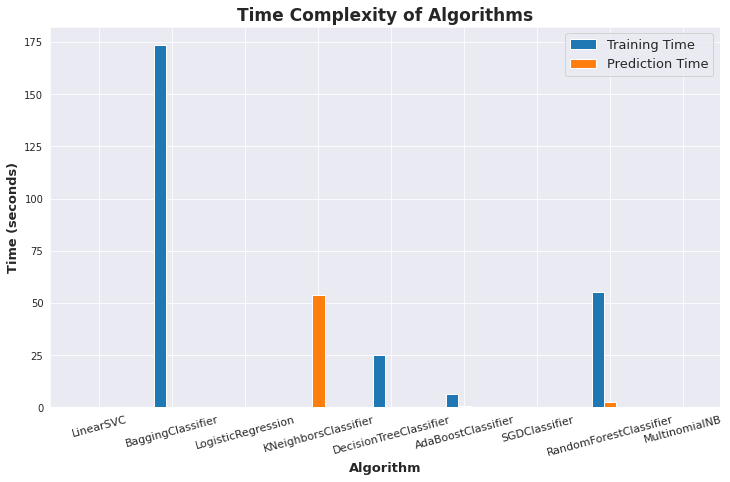

In [21]:
plt.figure(figsize = (12, 7))

barWidth = 0.17
 
# set height of bar
bars1 = results['Training Time']
bars2 = results['Prediction Time']
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, color= pal[0], width=barWidth, edgecolor='white', label='Training Time')
plt.bar(r2, bars2, color= pal[1], width=barWidth, edgecolor='white', label='Prediction Time')
 
# Add xticks on the middle of the group bars
plt.xlabel('Algorithm', fontweight='bold', fontsize = 13)
plt.ylabel('Time (seconds)', fontweight = 'bold', fontsize = 13)
plt.xticks([r + barWidth for r in range(len(bars1))], results['Algorithm'], rotation = 15, fontsize = 11)
 
# Create legend & Show graphic
plt.legend(fontsize = 13)

props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)

#place a text box
#plt.text(9, 36, textstr, fontsize=14,  bbox=props)

plt.title('Time Complexity of Algorithms', fontweight = 'bold', fontsize = 17);

# Evaluation with full dataset

In [23]:
percentage_used = 1
df_sample = df_lem.sample(frac=percentage_used, random_state=0)

X_train, X_test, y_train, y_test = train_test_split(df_sample['text'], df_sample['target'], test_size=0.3, random_state=0)

X_train = pd.DataFrame(data=X_train, columns=['text'])
X_test = pd.DataFrame(data=X_test, columns=['text'])

In [24]:
# make a list of vectorizers
vectorizers = [TfidfVectorizer()]

# make a list of models
models = [LinearSVC(),
          LogisticRegression(solver='liblinear'),
          SGDClassifier(),
          KNeighborsClassifier()
]

In [25]:
%%time

re = pipeline(vectorizers, models, X_train, y_train, X_test, y_test)
results = pd.DataFrame(re)

results = results.sort_values(by = 'f1', ascending = False).reset_index(drop = True)

best_model = results

results

CPU times: user 23min 46s, sys: 4min 36s, total: 28min 22s
Wall time: 28min 2s


,Vectorizer,Vectorizer Params,Algorithm,Algorithm Params,Training Time,Prediction Time,f1,recall,precision,accuracy
0,TfidfVectorizer,{},LinearSVC,{},1.28,0.02,0.6244,0.5506,0.7211,0.9207
1,TfidfVectorizer,{},LogisticRegression,{'solver': 'liblinear'},2.68,0.03,0.6133,0.4993,0.7948,0.9246
2,TfidfVectorizer,{},SGDClassifier,{},0.34,0.02,0.4489,0.3024,0.8709,0.9111
3,TfidfVectorizer,{},KNeighborsClassifier,{},0.02,1669.92,0.2119,0.2565,0.1805,0.7715


# Crossvalidation